# Bacterial cross-activity analysis 

**ToDo**  

Find an intro to the subject

<a target="_blank" href="https://colab.research.google.com/github/etienneguevel/mnhn_ia_nutrition/blob/master/notebooks/automatic_mask_generator_example.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

## Environment Set-up

If running locally using jupyter, first install `SAM 2` in your environment using the installation instructions in the repository.

If running from Google Colab, set `using_colab=True` below and run the cell. In Colab, be sure to select 'GPU' under 'Edit'->'Notebook Settings'->'Hardware accelerator'. Note that it's recommended to use **A100 or L4 GPUs when running in Colab** (T4 GPUs might also work, but could be slow and might run out of memory in some cases).

In [2]:
using_colab = False

In [3]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !git clone https://github.com/etienneguevel/mnhn_ia_nutrition.git
    !cd mnhn_ia_nutrition
    !{sys.executable} -m pip install .
    !cd notebooks

    !mkdir -p ../checkpoints/
    !wget -P ../checkpoints/ https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_large.pt

In [4]:
import os
# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image

In [5]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

using device: cuda


## Extract bacteria's images

### Visualize the images

Images of the cross-activations of our bacterias are contained within the images folder, let's visualize a few ones.

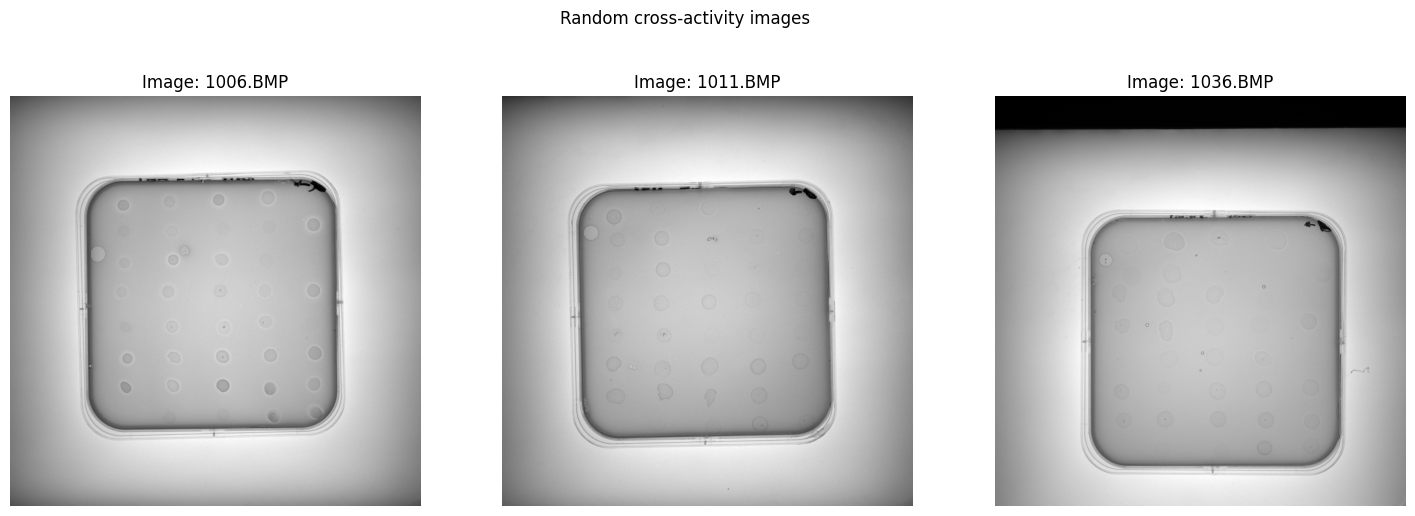

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random

from PIL import Image

image_dir = "./images"
images_list = os.listdir(image_dir)


fig, ax = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle("Random cross-activity images")

for i, path in enumerate(random.sample(images_list, 3)):
    image = Image.open(os.path.join(image_dir, path))
    image = np.array(image.convert("RGB"))

    ax[i].imshow(image)
    ax[i].axis("off")
    ax[i].set_title(f"Image: {path}")

plt.show()

We can see that the images are made of a petri dish containing circles, each one being one bacteria strand.  
For the TP we will focus on one image, on which we will apply different techniques. Image `1006.BMP` has a
nice contrast but feel free to select another one !

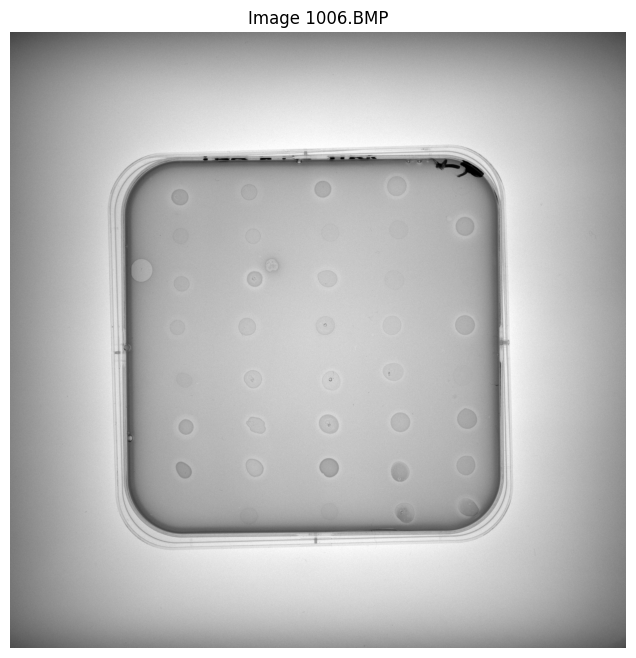

In [2]:
image = Image.open(os.path.join(image_dir, '1006.BMP'))
image = np.array(image.convert("RGB"))

fig = plt.figure(figsize=(8, 8))

plt.imshow(image)
plt.axis("off")
plt.title("Image 1006.BMP")

plt.show()

### Extract the petri dish

To begin, we'd like to isolate the petri dish from the rest of the image.  
For this, we are going to use an open-source model developped by Meta :
[SAM2](https://github.com/facebookresearch/sam2)  

This model is used to automatically segment the parts of interest contained
within a given image.

In [3]:
%%bash

rm -r ../checkpoints/
mkdir -p ../checkpoints/
wget -q -P ../checkpoints/ https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_large.pt

In [4]:
from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

# Build the model from checkpoints
sam2_checkpoint = "../checkpoints/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"

sam2 = build_sam2(model_cfg, sam2_checkpoint, apply_postprocessing=False, device="cpu")

mask_generator = SAM2AutomaticMaskGenerator(sam2)

To generate masks, just run `generate` on an image.

In [5]:
# Here image is the cross-activation image that we saw above
masks = mask_generator.generate(image)

Mask generation returns a list over masks, where each mask is a dictionary containing various data about the mask. These keys are:
* `segmentation` : the mask
* `area` : the area of the mask in pixels
* `bbox` : the boundary box of the mask in XYWH format
* `predicted_iou` : the model's own prediction for the quality of the mask
* `point_coords` : the sampled input point that generated this mask
* `stability_score` : an additional measure of mask quality
* `crop_box` : the crop of the image used to generate this mask in XYWH format

Show all the masks overlayed on the image.

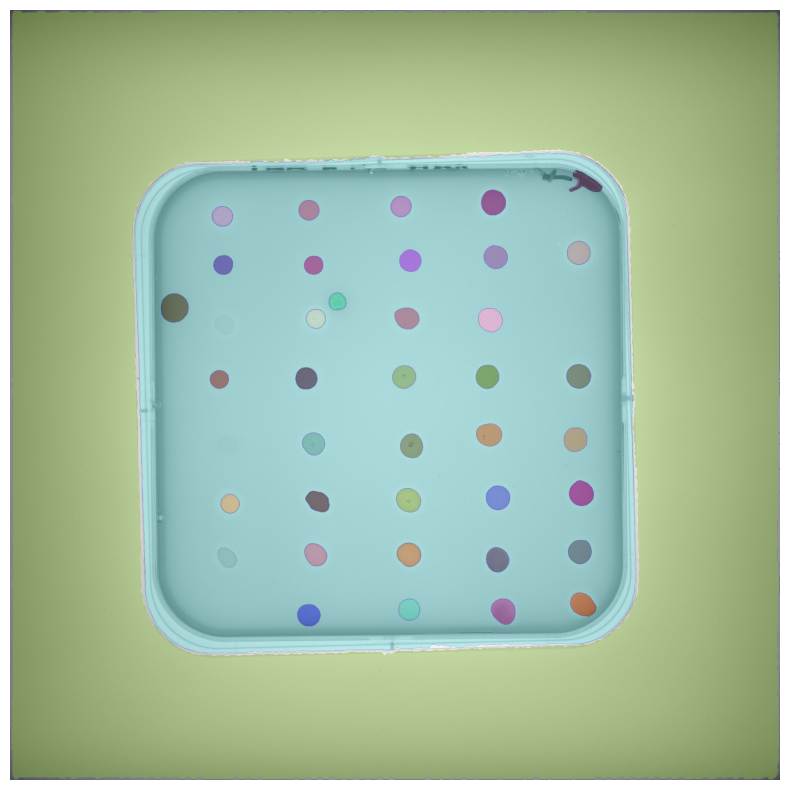

In [6]:
np.random.seed(3)

def show_anns(anns, borders=True, ax=None):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    if not ax:
        ax = plt.gca()
    
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:, :, 3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.5]])
        img[m] = color_mask 
        if borders:
            import cv2
            contours, _ = cv2.findContours(m.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
            # Try to smooth contours
            contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
            cv2.drawContours(img, contours, -1, (0, 0, 1, 0.4), thickness=1) 

    ax.imshow(img)

plt.figure(figsize=(10, 10))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show() 

Each color indicates an object that SAM2 found, among which are :
- The petri dish
- The background
- The bacterias

**ToDo** : within the `masks` (which is a list of dicts) one correspond to the one
of the petri dish, find it and then use the information contained within the dictionary  
to extract the petri dish out of the image.

In [7]:
print(masks[0])
print(masks[0].keys())

{'segmentation': array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]],
      shape=(2048, 2048)), 'area': 2458837, 'bbox': [4.0, 0.0, 2043.0, 2047.0], 'predicted_iou': 0.9957332015037537, 'point_coords': [[416.0, 1696.0]], 'stability_score': 0.9670068621635437, 'crop_box': [0.0, 0.0, 2048.0, 2048.0]}
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


In [43]:
# Write here the code in order to find the mask of the petri box, and isolate it from the image
# Uncomment and execute the cell below in order to see the answer

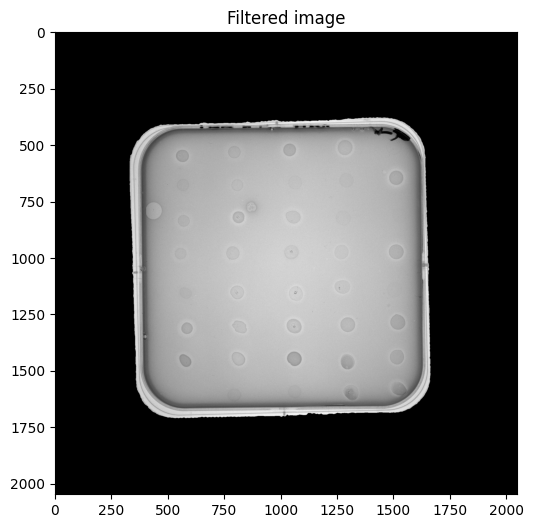

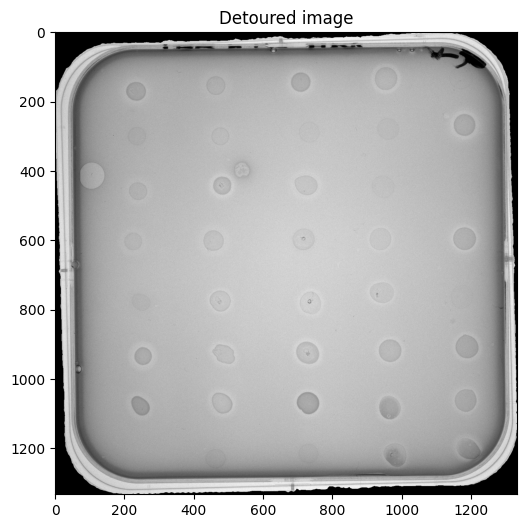

In [8]:
# The object corresponding to the box should be the 2nd one (idx 1)
mask_box = masks[1]

# Filter the points according to the mask
# We need to add one dimension to the mask generated by SAM2 in order to cop with the fact that an image is (height * width * 3)
m = np.transpose(np.array([mask_box["segmentation"] for i in range(image.shape[2])]), (1, 2, 0))
box_img_filt = image * m

fig = plt.figure(figsize=(6, 6))
plt.title("Filtered image")
plt.imshow(box_img_filt)
plt.show()

# Detour the box
x, y, w, h = mask_box["bbox"]
x, y, w, h = int(x), int(y), int(w), int(h)
box_img = box_img_filt[y:y+h, x:x+w]

fig = plt.figure(figsize=(6, 6))
plt.title("Detoured image")
plt.imshow(box_img)
plt.show()

### Find the bacterias within the cell 

Now that we have the petri dish, we can repeat this operation on the box image.

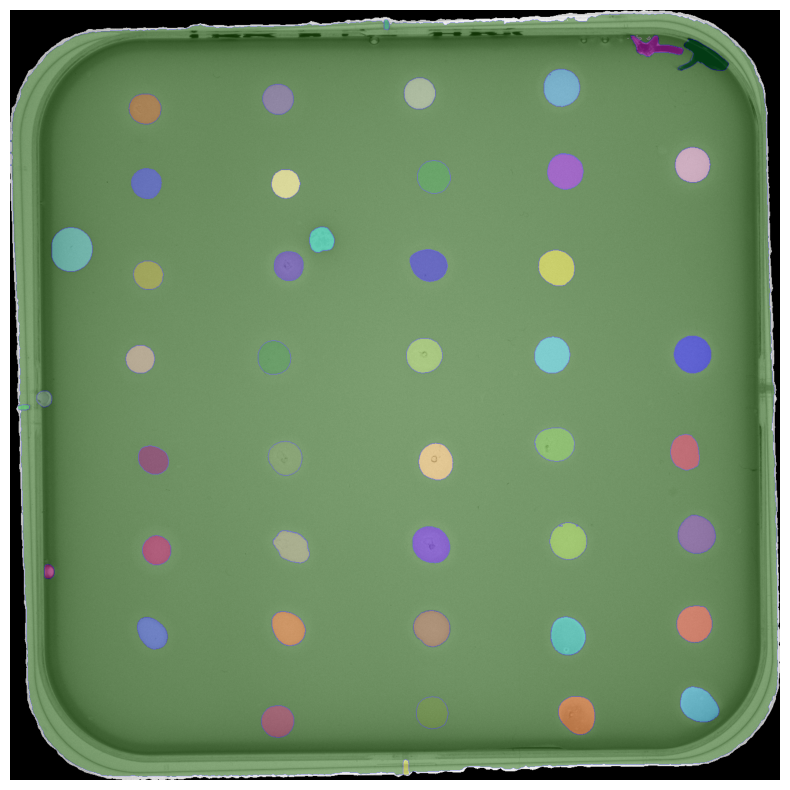

In [9]:
# Use SAM2 on the box image, and look at the obtained image
box_masks = mask_generator.generate(box_img)

plt.figure(figsize=(10, 10))
plt.imshow(box_img)
show_anns(box_masks)
plt.axis('off')
plt.show() 

In [10]:
def cut_image(image, mask, res=112):
    
    n, m = image.shape[0], image.shape[1]
    x, y, w, h = mask["bbox"]
    x, y, w, h = int(x), int(y), int(h), int(w)
    xc, yc = x + w//2, y + h//2
    
    cut = image[yc - res//2:yc + res//2, xc - res//2:xc + res//2]
    
    return (cut, xc, yc)

def get_cells(image, masks, res=112):
    ths = 5 * np.median([m["area"] for m in masks])
    imgs = [cut_image(image, m) for m in masks if m["area"] < ths]

    return imgs

In [11]:
cells = get_cells(box_img, box_masks)
len(cells[0])

3

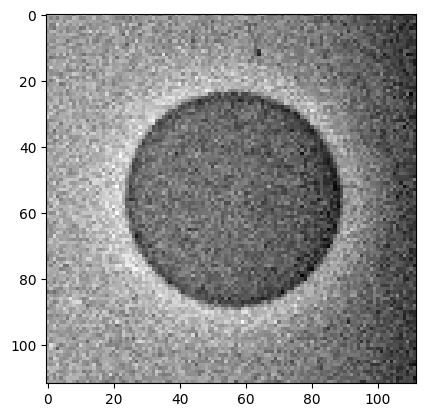

In [12]:
import cv2

i = 15
img, xc, yc = cells[i] 
img_gray = gray_image = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

plt.imshow(img_gray, cmap="grey")
plt.show()

### Find the halos

We are now able to isolate the bacterias if we have their correct positions! However,
what interests us the most is the size of the halo around them.  
Some halos can already be detected on the original images, but most of them are too faint.

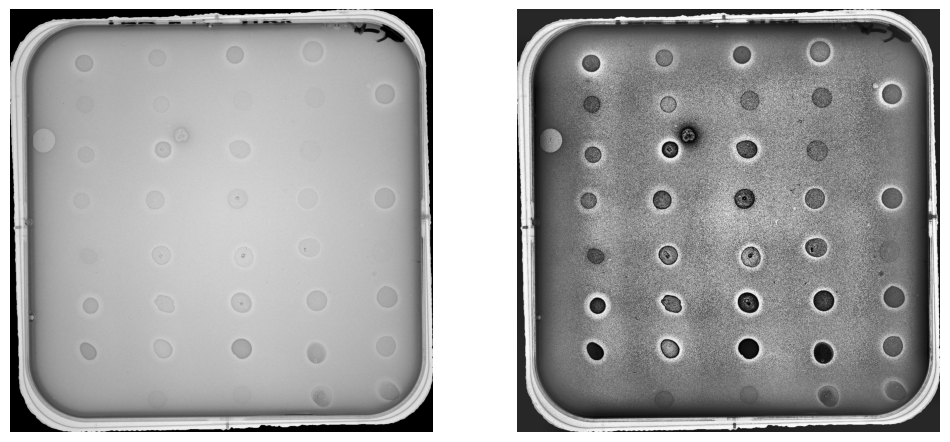

In [13]:
# Convert to LAB color space
lab = cv2.cvtColor(box_img, cv2.COLOR_BGR2LAB)

# Split channels
l, a, b = cv2.split(lab)

# Apply CLAHE on the L (lightness) channel
clahe = cv2.createCLAHE(clipLimit=40.0, tileGridSize=(8,8))
l_eq = clahe.apply(l)

# Merge channels back
lab_eq = cv2.merge((l_eq, a, b))

# Convert back to BGR
image_eq = cv2.cvtColor(lab_eq, cv2.COLOR_LAB2BGR)


fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].imshow(box_img)
ax[0].axis("off")
ax[1].imshow(image_eq)
ax[1].axis("off")
plt.show()

In [14]:
mask_generator_2 = SAM2AutomaticMaskGenerator(
    model=sam2,
    points_per_side=64,
    points_per_batch=128,
    pred_iou_thresh=0.7,
    stability_score_thresh=0.92,
    stability_score_offset=0.7,
    crop_n_layers=1,
    box_nms_thresh=0.7,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=25.0,
    use_m2m=True,
)

In [ ]:
# Detect masks with the original model
box_masks = mask_generator.generate(image_eq)

# Use SAM2 on the box image, and look at the obtained image
box_masks_2 = mask_generator_2.generate(image_eq)

/home/etienneguevel/Documents/SCAI/mnhn/mnhn_ia_nutrition/.venv/lib/python3.11/site-packages/sam2/sam2_image_predictor.py:431: UserWarning: cannot import name '_C' from 'sam2' (/home/etienneguevel/Documents/SCAI/mnhn/mnhn_ia_nutrition/.venv/lib/python3.11/site-packages/sam2/__init__.py)

Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/sam2/blob/main/INSTALL.md).
  masks = self._transforms.postprocess_masks(


In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(image_eq)
show_anns(filtered_masks, ax=ax[0])
ax[0].axis('off')

ax[1].imshow(image_eq)
show_anns(box_masks_2, ax=ax[1])
ax[1].axis('off')

plt.show()

In [ ]:
len(cells)

## Example image

In [74]:
import cv2

# Load image
image_gray = cv2.imread('images/activites_croisees/988.BMP', cv2.IMREAD_GRAYSCALE)  # Read in grayscale

In [75]:
cells = get_cells(image_gray, masks)

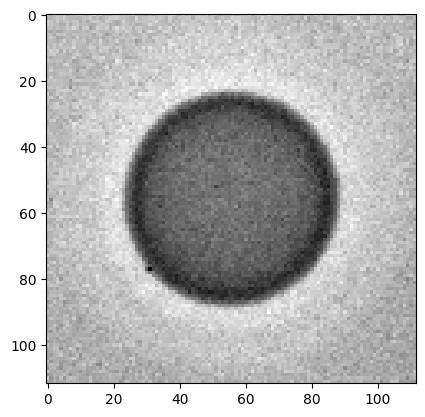

In [76]:
import matplotlib.pyplot as plt

cells = get_cells(image_gray, masks)
i = 15
img, xc, yc = cells[i] 

plt.imshow(img, cmap="grey")
plt.show()

In [78]:
img

array([[229, 223, 228, ..., 227, 228, 224],
       [225, 224, 227, ..., 220, 220, 225],
       [232, 228, 225, ..., 224, 226, 223],
       ...,
       [215, 218, 224, ..., 218, 223, 225],
       [229, 214, 222, ..., 210, 220, 223],
       [223, 217, 223, ..., 218, 217, 216]], shape=(112, 112), dtype=uint8)

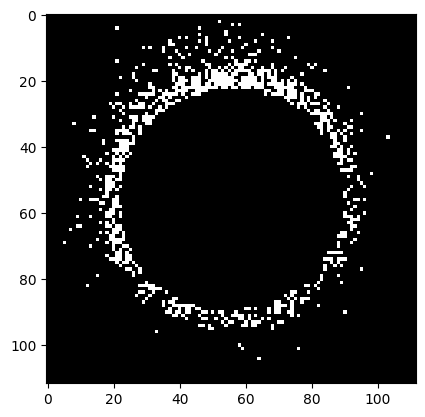

In [77]:
th=235
max_val=240
ret, o1 = cv2.threshold(img, th, max_val, cv2.THRESH_BINARY)

plt.imshow(o1, cmap="gray")

## Isolate the box

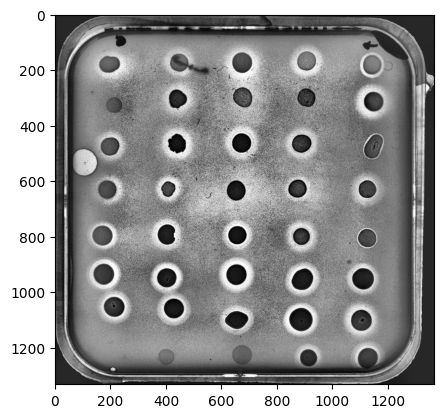

In [20]:
# Convert to LAB color space
lab = cv2.cvtColor(box_img, cv2.COLOR_BGR2LAB)

# Split channels
l, a, b = cv2.split(lab)

# Apply CLAHE on the L (lightness) channel
clahe = cv2.createCLAHE(clipLimit=40.0, tileGridSize=(8,8))
l_eq = clahe.apply(l)

# Merge channels back
lab_eq = cv2.merge((l_eq, a, b))

# Convert back to BGR
image_eq = cv2.cvtColor(lab_eq, cv2.COLOR_LAB2BGR)

plt.imshow(image_eq)
plt.show()

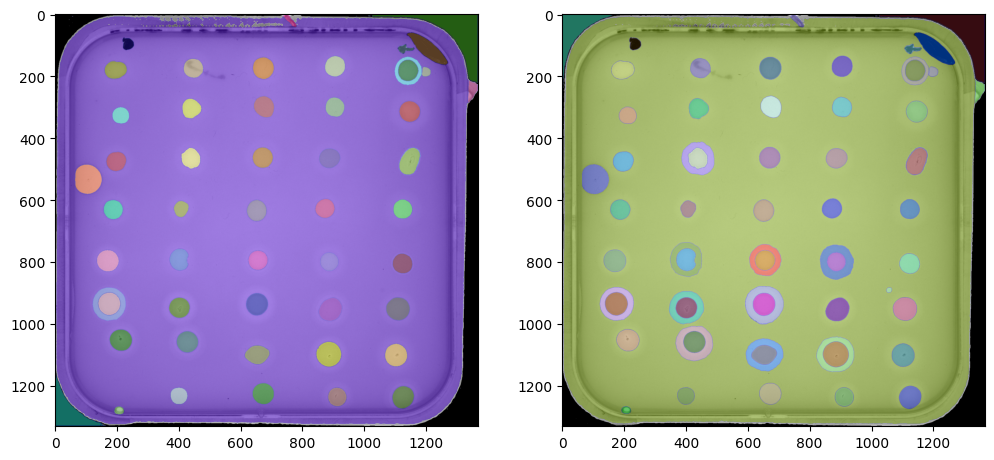

In [21]:
masks_box = mask_generator.generate(box_img)
masks_box_c = mask_generator.generate(image_eq)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(box_img)
show_anns(masks_box, ax=axes[0])

axes[1].imshow(box_img)
show_anns(masks_box_c, ax=axes[1])